# Attention-based BiLSTM for Sentiment Analysis

## Aspect based sentimental analysis with LSTM (Long Short-Term Memory) 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samarthmahendra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:__main__:Combined dataset shape: (2676, 2)
INFO:__main__:Processed dataframe shape: (2363, 3)
INFO:__main__:Sample of processed dataframe:
INFO:__main__:                                            raw_text aspect_term  \
0  Judging from previous posts this used to be a ...       place   
1  We, there were four of us, arrived at noon - t...       staff   
2  The food was lousy - too sweet or too salty an...        food   
3  The food was lousy - too sweet or too salty an...    portions   
4                                  Avoid this place!       place   

   polarity_encoded  
0                 2  
1                 2  
2                 2  
3                 2  
4                 2  
INFO:__main__:Training set size: 1890
INFO:__main__:Testing set size: 473
INFO:__main__:Training set label distribution: Counter({1: 1366, 2: 445, 0: 79})
IN

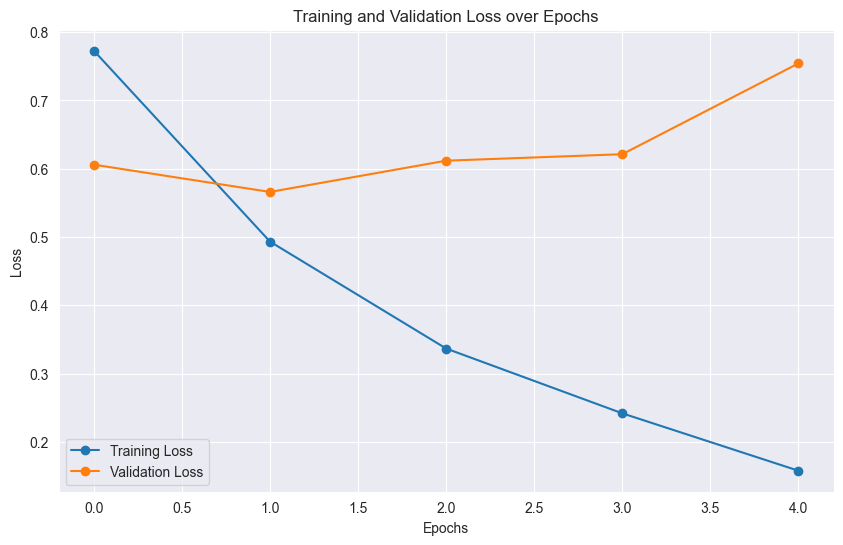

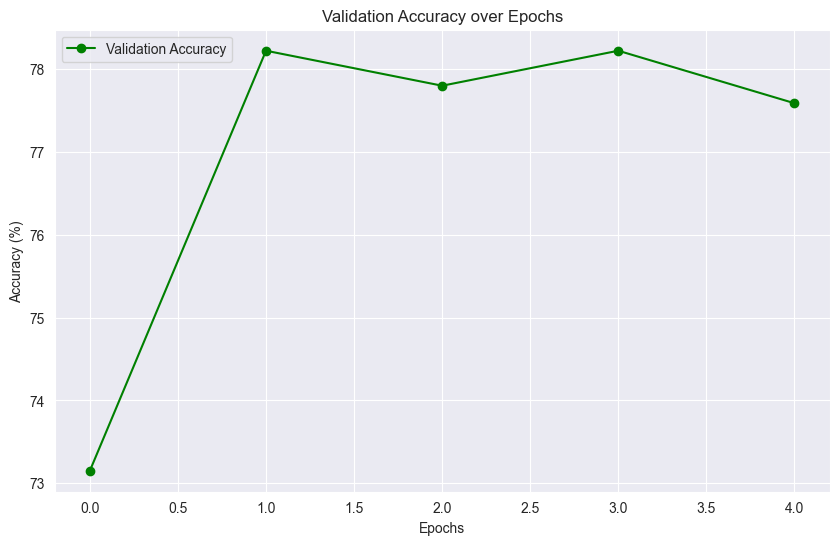

INFO:__main__:
Classification Report:
              precision    recall  f1-score   support

     neutral     0.2143    0.1500    0.1765        20
    positive     0.8788    0.8480    0.8631       342
    negative     0.5736    0.6667    0.6167       111
    conflict     0.0000    0.0000    0.0000         0

    accuracy                         0.7759       473
   macro avg     0.4167    0.4162    0.4141       473
weighted avg     0.7791    0.7759    0.7762       473

INFO:__main__:Classification report saved to 'classification_report.txt'.


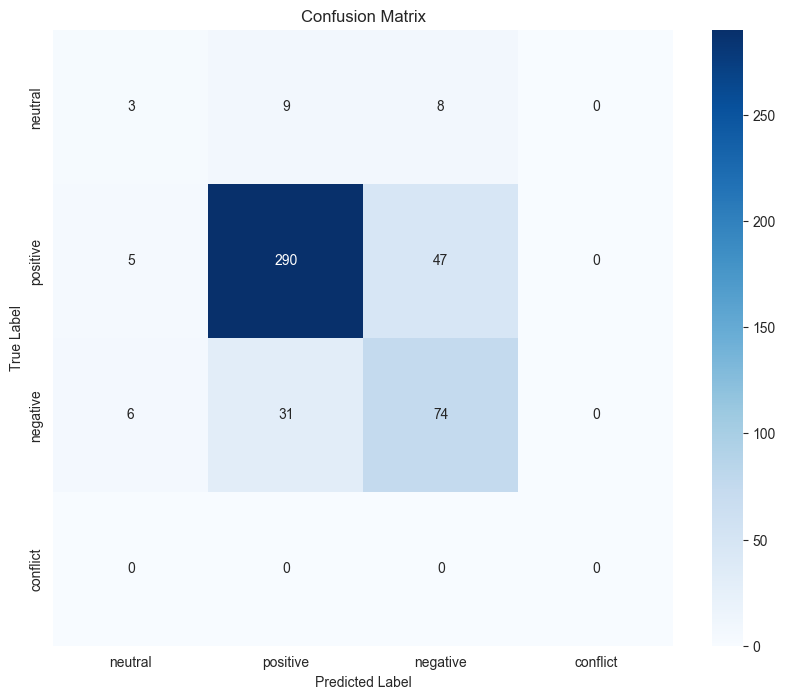

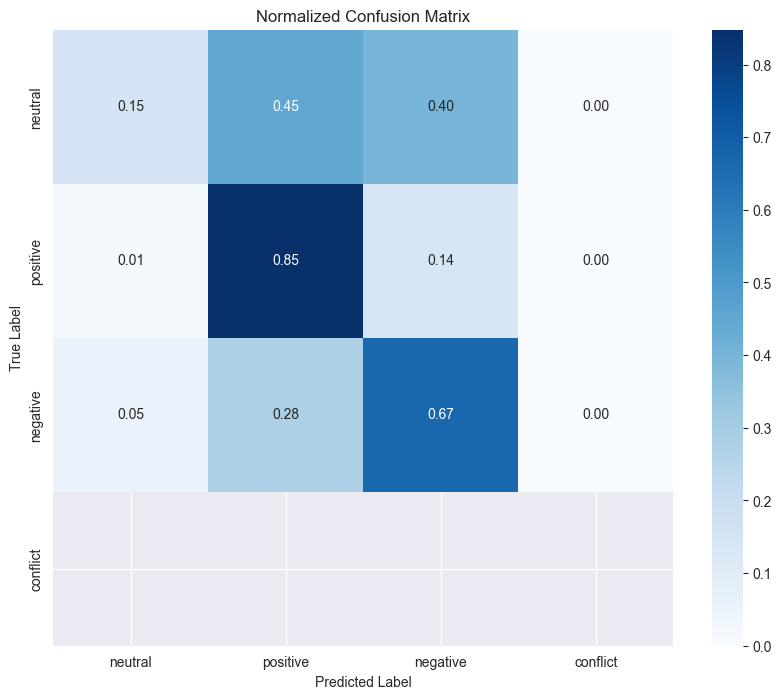

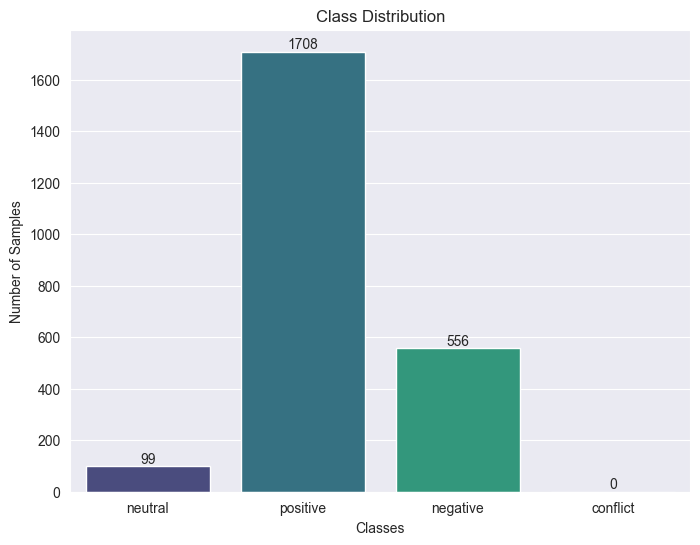


              precision    recall  f1-score   support

     neutral     0.2143    0.1500    0.1765        20
    positive     0.8788    0.8480    0.8631       342
    negative     0.5736    0.6667    0.6167       111
    conflict     0.0000    0.0000    0.0000         0

    accuracy                         0.7759       473
   macro avg     0.4167    0.4162    0.4141       473
weighted avg     0.7791    0.7759    0.7762       473



In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import numpy as np
import pandas as pd
import re
import logging
from collections import Counter
from typing import List, Tuple, Dict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('punkt')

# Import custom preprocessing functions
# Ensure these modules are accessible in your project structure
from src.preprocessing.preprocess_dataframe import preprocess_dataframe

# Configure Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Polarity Encoding Mapping (including 'conflict')
polarity_encoding = {
    'neutral': 0,
    'positive': 1,
    'negative': 2,
    'conflict': 3,  # Add 'conflict' to the mapping
}

# Load the Data
train_csv_path = "data/SemEval16/Train/Restaurants_Train.csv"
test_csv_path = "data/SemEval16/Test/Restaurants_Test.csv"

restaurant_df_train = pd.read_csv(train_csv_path, encoding='utf8')
test_df = pd.read_csv(test_csv_path, encoding='utf8')

# Combine Train and Test Data
df = pd.concat([restaurant_df_train, test_df], ignore_index=True)
logger.info(f"Combined dataset shape: {df.shape}")

# Apply Preprocessing
new_df = preprocess_dataframe(df)
logger.info("Dataframe after preprocessing:")
logger.info(new_df.head())

# Function to Clean Text
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Apply Text Cleaning
new_df['raw_text'] = new_df['raw_text'].apply(clean_text)
new_df['aspect_term'] = new_df['aspect_term'].apply(clean_text)

# Prepare Features and Labels
X_raw_text = new_df['raw_text'].tolist()
X_aspect = new_df['aspect_term'].tolist()
y = new_df['polarity_encoded'].values

from sklearn.model_selection import train_test_split

# First, split off the test set (15%)
X_train_val_text, X_test_text, X_train_val_aspect, X_test_aspect, y_train_val, y_test = train_test_split(
    X_raw_text, X_aspect, y, test_size=0.15, random_state=42, stratify=y
)

# Then, split the remaining 85% into 70% train and 15% validation
# The validation size relative to the train_val set is 15/85 ≈ 0.1765
X_train_text, X_val_text, X_train_aspect, X_val_aspect, y_train, y_val = train_test_split(
    X_train_val_text, X_train_val_aspect, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

# Logging
logger.info(f"Training set size: {len(X_train_text)} ({len(X_train_text)/len(X_raw_text)*100:.2f}%)")
logger.info(f"Validation set size: {len(X_val_text)} ({len(X_val_text)/len(X_raw_text)*100:.2f}%)")
logger.info(f"Test set size: {len(X_test_text)} ({len(X_test_text)/len(X_raw_text)*100:.2f}%)")

# Vocabulary Builder Class
class VocabularyBuilder:
    def __init__(self, min_freq: int = 2):
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.word_freq = Counter()
        self.min_freq = min_freq

    def build_vocab(self, texts: List[str]) -> None:
        """Build vocabulary from list of texts"""
        for text in texts:
            words = text.split()
            self.word_freq.update(words)

        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        logger.info(f"Vocabulary size: {len(self.word2idx)}")

    def text_to_indices(self, text: str) -> List[int]:
        """Convert text to list of indices"""
        return [self.word2idx.get(word, self.word2idx['<unk>']) for word in text.split()]

# Dataset Class
class AspectSentimentDataset(Dataset):
    def __init__(self, texts: List[str], aspects: List[str], labels: np.ndarray, vocab: VocabularyBuilder):
        self.texts = texts
        self.aspects = aspects
        self.labels = torch.LongTensor(labels)
        self.vocab = vocab

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        text_indices = torch.LongTensor(self.vocab.text_to_indices(self.texts[idx]))
        aspect_indices = torch.LongTensor(self.vocab.text_to_indices(self.aspects[idx]))
        return text_indices, aspect_indices, self.labels[idx]

# Collate Function for DataLoader
def collate_fn(batch: List[Tuple]) -> Tuple:
    """Custom collate function to handle variable length sequences"""
    texts, aspects, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    aspects_padded = pad_sequence(aspects, batch_first=True, padding_value=0)
    return texts_padded, aspects_padded, torch.stack(labels)

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim: int):
        super(AttentionLayer, self).__init__()
        # Adjusting dimensions: hidden_dim is the size of BiLSTM output (hidden_dim * 2)
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, encoder_outputs: torch.Tensor, mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # encoder_outputs shape: (batch_size, seq_len, hidden_dim * 2)

        # Calculate attention scores
        attention_scores = self.attention(encoder_outputs).squeeze(-1)  # (batch_size, seq_len)

        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)

        # Apply attention weights to encoder outputs
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return weighted_output, attention_weights

# Aspect Attention LSTM Model
class AspectAttentionLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_classes: int, num_layers: int = 2,
                 dropout: float = 0.5):
        super(AspectAttentionLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Bidirectional LSTM layers
        self.sentence_lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.aspect_lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layers for sentence and aspect
        self.sentence_attention = AttentionLayer(hidden_dim)
        self.aspect_attention = AttentionLayer(hidden_dim)

        # Output layers
        self.dropout = nn.Dropout(dropout)
        # Using concatenated attended outputs from both LSTMs
        self.fc1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def create_mask(self, tensor: torch.Tensor) -> torch.Tensor:
        """Create mask for padding tokens (0)"""
        return (tensor != 0).float()

    def forward(self, sentence: torch.Tensor, aspect: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Create masks for padding
        sentence_mask = self.create_mask(sentence)
        aspect_mask = self.create_mask(aspect)

        # Embed inputs
        sentence_embedded = self.embedding(sentence)  # (batch_size, seq_len, embed_dim)
        aspect_embedded = self.embedding(aspect)  # (batch_size, aspect_len, embed_dim)

        # Process through BiLSTM
        sentence_outputs, _ = self.sentence_lstm(sentence_embedded)  # (batch_size, seq_len, hidden_dim*2)
        aspect_outputs, _ = self.aspect_lstm(aspect_embedded)  # (batch_size, aspect_len, hidden_dim*2)

        # Apply attention
        sentence_context, sentence_weights = self.sentence_attention(sentence_outputs, sentence_mask)
        aspect_context, aspect_weights = self.aspect_attention(aspect_outputs, aspect_mask)

        # Concatenate the attended outputs
        combined = torch.cat((sentence_context, aspect_context), dim=1)

        # Final classification
        output = self.dropout(combined)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)

        return output, sentence_weights, aspect_weights

# Training Function
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int,
                device: torch.device) -> Dict:
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0.0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch_idx, (texts, aspects, labels) in enumerate(train_loader):
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _, _ = model(texts, aspects)  # Ignore attention weights during training
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, aspects, labels in val_loader:
                texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
                outputs, _, _ = model(texts, aspects)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        logger.info(f'Epoch {epoch + 1}/{num_epochs}:')
        logger.info(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_attention.pth')
            logger.info("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info("Early stopping triggered")
                break

    return history

# Evaluation Function
def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Dict:
    model.eval()
    all_predictions = []
    all_labels = []
    all_sentence_attention = []
    all_aspect_attention = []

    with torch.no_grad():
        for texts, aspects, labels in test_loader:
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
            outputs, sentence_attention, aspect_attention = model(texts, aspects)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_sentence_attention.extend(sentence_attention.cpu().numpy())
            all_aspect_attention.extend(aspect_attention.cpu().numpy())

    report = classification_report(all_labels, all_predictions, digits=4)
    logger.info("\nClassification Report:")
    logger.info(f"\n{report}")

    return {
        'predictions': all_predictions,
        'true_labels': all_labels,
        'sentence_attention': all_sentence_attention,
        'aspect_attention': all_aspect_attention,
        'classification_report': report
    }

# Check Device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
logger.info(f'Using device: {device}')

# Define Hyperparameters
EMBED_DIM = 300
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
MIN_WORD_FREQ = 2

# Build Vocabulary
vocab_builder = VocabularyBuilder(min_freq=MIN_WORD_FREQ)
vocab_builder.build_vocab(X_train_text + X_train_aspect + X_val_text + X_val_aspect)

# Create Datasets
train_dataset = AspectSentimentDataset(
    texts=X_train_text,
    aspects=X_train_aspect,
    labels=y_train,
    vocab=vocab_builder
)
val_dataset = AspectSentimentDataset(
    texts=X_val_text,
    aspects=X_val_aspect,
    labels=y_val,
    vocab=vocab_builder
)
test_dataset = AspectSentimentDataset(
    texts=X_test_text,
    aspects=X_test_aspect,
    labels=y_test,
    vocab=vocab_builder
)

# Create Data Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

logger.info(f"Number of training batches: {len(train_loader)}")
logger.info(f"Number of validation batches: {len(val_loader)}")
logger.info(f"Number of testing batches: {len(test_loader)}")

# Initialize model with attention
model = AspectAttentionLSTM(
    vocab_size=len(vocab_builder.word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=4,  # Including 'conflict'
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)
logger.info("Model initialized.")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

# Load the best model
model.load_state_dict(torch.load('best_model_attention.pth'))
logger.info("Best model loaded for evaluation.")

# Evaluate the model on the Test Set
evaluation_results = evaluate_model(model, test_loader, device)


## Aspect based sentimental analysis with Attention based LSTM (Long Short-Term Memory)

In [52]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
from collections import Counter
import torch.optim as optim
from typing import List, Tuple, Dict
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim: int):
        super(AttentionLayer, self).__init__()
        # Adjusting dimensions: hidden_dim is the size of BiLSTM output (hidden_dim * 2)
        self.attention = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, encoder_outputs: torch.Tensor, mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # encoder_outputs shape: (batch_size, seq_len, hidden_dim * 2)
        
        # Calculate attention scores
        attention_scores = self.attention(encoder_outputs).squeeze(-1)  # (batch_size, seq_len)
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
            
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        
        # Apply attention weights to encoder outputs
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return weighted_output, attention_weights

class AspectAttentionLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_classes: int, num_layers: int = 2, dropout: float = 0.5):
        super(AspectAttentionLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Bidirectional LSTM layers
        self.sentence_lstm = nn.LSTM(
            embed_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.aspect_lstm = nn.LSTM(
            embed_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention layers for sentence and aspect
        self.sentence_attention = AttentionLayer(hidden_dim)
        self.aspect_attention = AttentionLayer(hidden_dim)
        
        # Output layers
        self.dropout = nn.Dropout(dropout)
        # Using concatenated attended outputs from both LSTMs
        self.fc1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def create_mask(self, tensor: torch.Tensor) -> torch.Tensor:
        """Create mask for padding tokens (0)"""
        return (tensor != 0).float()

    def forward(self, sentence: torch.Tensor, aspect: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Create masks for padding
        sentence_mask = self.create_mask(sentence)
        aspect_mask = self.create_mask(aspect)
        
        # Embed inputs
        sentence_embedded = self.embedding(sentence)  # (batch_size, seq_len, embed_dim)
        aspect_embedded = self.embedding(aspect)      # (batch_size, aspect_len, embed_dim)
        
        # Process through BiLSTM
        sentence_outputs, _ = self.sentence_lstm(sentence_embedded)  # (batch_size, seq_len, hidden_dim*2)
        aspect_outputs, _ = self.aspect_lstm(aspect_embedded)        # (batch_size, aspect_len, hidden_dim*2)
        
        # Apply attention
        sentence_context, sentence_weights = self.sentence_attention(sentence_outputs, sentence_mask)
        aspect_context, aspect_weights = self.aspect_attention(aspect_outputs, aspect_mask)
        
        # Concatenate the attended outputs
        combined = torch.cat((sentence_context, aspect_context), dim=1)
        
        # Final classification
        output = self.dropout(combined)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        
        return output, sentence_weights, aspect_weights

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int, 
                device: torch.device) -> Dict:
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0.0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for batch_idx, (texts, aspects, labels) in enumerate(train_loader):
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _, _ = model(texts, aspects)  # Ignore attention weights during training
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, aspects, labels in val_loader:
                texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
                outputs, _, _ = model(texts, aspects)
                loss = criterion(outputs, labels)
                
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_attention.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return history

def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Dict:
    model.eval()
    all_predictions = []
    all_labels = []
    all_sentence_attention = []
    all_aspect_attention = []

    with torch.no_grad():
        for texts, aspects, labels in test_loader:
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
            outputs, sentence_attention, aspect_attention = model(texts, aspects)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_sentence_attention.extend(sentence_attention.cpu().numpy())
            all_aspect_attention.extend(aspect_attention.cpu().numpy())

    report = classification_report(all_labels, all_predictions, digits=4)
    print("\nClassification Report:")
    print(report)

    return {
        'predictions': all_predictions,
        'true_labels': all_labels,
        'sentence_attention': all_sentence_attention,
        'aspect_attention': all_aspect_attention,
        'classification_report': report
    }

# Initialize model with attention
model = AspectAttentionLSTM(
    vocab_size=len(vocab_builder.word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=4,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

# Evaluate the model
evaluation_results = evaluate_model(model, test_loader, device)

ValueError: too many values to unpack (expected 3)

## Aspect based sentimental analysis with ATAE-LSTM (Aspect Term Attention based LSTM)

In [51]:
# Import necessary libraries
from typing import Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Import the preprocessing function
from src.preprocessing.preprocess_dataframe import preprocess_dataframe

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using device: {device}')

# Define hyperparameters
EMBED_DIM = 300
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
BATCH_SIZE = 32
MAX_LEN = 100
NUM_CLASSES = 4  # neutral, positive, negative, conflict

# Define polarity encoding
polarity_encoding = {
    'neutral': 0,
    'positive': 1,
    'negative': 2,
    'conflict': 3,
}

# Define file paths
train_path = "data/SemEval16/Train/Restaurants_Train.csv"
test_path = "data/SemEval16/Test/Restaurants_Test.csv"

# Load the training and testing data
restaurant_df_train = pd.read_csv(train_path, encoding='utf8')
test_df_original = pd.read_csv(test_path, encoding='utf8')

# Combine train and test data for preprocessing
df = pd.concat([restaurant_df_train, test_df_original], ignore_index=True)

# Apply preprocessing
new_df = preprocess_dataframe(df)

# Split into train (70%) and temp (30%) sets with stratification
train_df, temp_df = train_test_split(
    new_df,
    test_size=0.30,
    random_state=SEED,
    stratify=new_df['polarity_encoded']
)

# Further split temp into validation (15%) and test (15%) sets
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # 50% of 30% is 15%
    random_state=SEED,
    stratify=temp_df['polarity_encoded']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class AspectDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['raw_text']
        aspect = row['aspect_term']
        label = row['polarity_encoded']

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize the aspect
        aspect_encoding = self.tokenizer.encode_plus(
            aspect,
            add_special_tokens=True,
            max_length=10,  # assuming aspect terms are short
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Squeeze to remove extra dimensions
        input_ids = encoding['input_ids'].squeeze()
        aspect_ids = aspect_encoding['input_ids'].squeeze()

        return input_ids, aspect_ids, torch.tensor(label, dtype=torch.long)


# Create datasets
train_dataset = AspectDataset(train_df, tokenizer, MAX_LEN)
val_dataset = AspectDataset(val_df, tokenizer, MAX_LEN)
test_dataset = AspectDataset(test_df, tokenizer, MAX_LEN)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


class ATAEAttentionLayer(nn.Module):
    def __init__(self, hidden_dim: int):
        super(ATAEAttentionLayer, self).__init__()
        # Accommodate concatenated hidden states and aspect embeddings
        self.attention = nn.Linear(hidden_dim * 4, 1)  # hidden_dim * 2 (BiLSTM) * 2 (hidden + aspect)

    def forward(self,
                encoder_outputs: torch.Tensor,
                aspect_embedding: torch.Tensor,
                mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # encoder_outputs: (batch_size, seq_len, hidden_dim * 2)
        # aspect_embedding: (batch_size, hidden_dim * 2)

        batch_size, seq_len, hidden_dim = encoder_outputs.size()

        # Repeat aspect_embedding across the sequence length
        aspect_repeated = aspect_embedding.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_dim * 2)

        # Concatenate encoder outputs with aspect embeddings
        combined = torch.cat([encoder_outputs, aspect_repeated], dim=2)  # (batch_size, seq_len, hidden_dim * 4)

        # Calculate attention scores
        attention_scores = self.attention(combined).squeeze(-1)  # (batch_size, seq_len)

        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)

        # Apply attention weights to encoder outputs
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(
            1)  # (batch_size, hidden_dim * 2)

        return weighted_output, attention_weights


class ATAELSTM(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int,
                 hidden_dim: int,
                 num_classes: int,
                 num_layers: int = 2,
                 dropout: float = 0.5,
                 pretrained_embeddings: torch.Tensor = None):
        super(ATAELSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        # Embedding layer for both words and aspects
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Main LSTM
        self.lstm = nn.LSTM(
            embed_dim + embed_dim,  # word embedding + aspect embedding
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Aspect LSTM
        self.aspect_lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # ATAE attention layer
        self.attention = ATAEAttentionLayer(hidden_dim)

        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def create_mask(self, tensor: torch.Tensor) -> torch.Tensor:
        """Create mask for padding tokens (0)"""
        return (tensor != 0).float()

    def forward(self, sentence: torch.Tensor, aspect: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Create masks
        sentence_mask = self.create_mask(sentence)

        # Embed inputs
        sentence_embedded = self.embedding(sentence)  # (batch_size, seq_len, embed_dim)
        aspect_embedded = self.embedding(aspect)  # (batch_size, aspect_len, embed_dim)

        # Get aspect representation
        aspect_output, (aspect_hidden, _) = self.aspect_lstm(aspect_embedded)
        # Concatenate forward and backward hidden states
        aspect_repr = torch.cat([aspect_hidden[-2], aspect_hidden[-1]], dim=1)  # (batch_size, hidden_dim * 2)

        # Repeat aspect embedding for each word in the sentence
        batch_size, seq_len, _ = sentence_embedded.size()
        aspect_repeated = aspect_embedded.mean(1).unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate word embeddings with repeated aspect embeddings
        combined_input = torch.cat([sentence_embedded, aspect_repeated], dim=2)

        # Process through LSTM
        lstm_outputs, _ = self.lstm(combined_input)

        # Apply attention
        attended_output, attention_weights = self.attention(
            lstm_outputs,
            aspect_repr,
            sentence_mask
        )

        # Final classification
        output = self.dropout(attended_output)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)

        return output, attention_weights


def train_atae_model(model: nn.Module,
                     train_loader: DataLoader,
                     val_loader: DataLoader,
                     criterion: nn.Module,
                     optimizer: optim.Optimizer,
                     num_epochs: int,
                     device: torch.device) -> Dict:
    """
    Train the ATAE-LSTM model.

    Args:
        model (nn.Module): The ATAE-LSTM model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        num_epochs (int): Number of epochs to train.
        device (torch.device): Device to train on.

    Returns:
        Dict: Training history containing losses and accuracies.
    """
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0.0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch_idx, (texts, aspects, labels) in enumerate(train_loader):
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(texts, aspects)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, aspects, labels in val_loader:
                texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
                outputs, _ = model(texts, aspects)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early Stopping and Checkpointing
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_atae.pth')
            print("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return history


def evaluate_atae_model(model: nn.Module, data_loader: DataLoader, device: torch.device) -> Dict:
    """
    Evaluate the ATAE-LSTM model.

    Args:
        model (nn.Module): The trained ATAE-LSTM model.
        data_loader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to evaluate on.

    Returns:
        Dict: Evaluation results including predictions, true labels, attention weights, and classification report.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_attention_weights = []

    with torch.no_grad():
        for texts, aspects, labels in data_loader:
            texts, aspects, labels = texts.to(device), aspects.to(device), labels.to(device)
            outputs, attention_weights = model(texts, aspects)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_attention_weights.extend(attention_weights.cpu().numpy())

    report = classification_report(all_labels, all_predictions, digits=4)
    print("\nClassification Report:")
    print(report)

    return {
        'predictions': all_predictions,
        'true_labels': all_labels,
        'attention_weights': all_attention_weights,
        'classification_report': report
    }


# Initialize the model
# Use tokenizer's vocab size
vocab_size = tokenizer.vocab_size
model = ATAELSTM(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pretrained_embeddings=None  # Replace with pretrained_embeddings if available
).to(device)

# Compute class weights to handle class imbalance
y_train = train_df['polarity_encoded'].tolist()
class_counts = Counter(y_train)
print("Class Counts:", class_counts)

total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights.get(i, 1.0) for i in range(NUM_CLASSES)], dtype=torch.float32).to(device)
print("Class Weights:", weights)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Define optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Train the model
history = train_atae_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,  # Use validation set
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

# Load the best model
model.load_state_dict(torch.load('best_model_atae.pth'))
print("Best model loaded for evaluation.")

# Evaluate on Validation Set
print("\nEvaluating on Validation Set:")
evaluation_val = evaluate_atae_model(model, val_loader, device)

# Evaluate on Test Set
print("\nEvaluating on Test Set:")
evaluation_test = evaluate_atae_model(model, test_loader, device)

# (Optional) Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# (Optional) Plotting Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Using device: mps
Training samples: 1890
Testing samples: 473
Number of training batches: 60
Number of validation batches: 15
Class Counts: Counter({1: 1366, 2: 445, 0: 79})
Class Weights: tensor([23.9241,  1.3836,  4.2472,  1.0000], device='mps:0')
Epoch 1/20:
Train Loss: 1.1373, Val Loss: 1.1299, Val Accuracy: 63.85%
Best model saved.
Epoch 2/20:
Train Loss: 0.9462, Val Loss: 1.2655, Val Accuracy: 65.75%
Best model saved.
Epoch 3/20:
Train Loss: 0.6633, Val Loss: 1.2162, Val Accuracy: 72.30%
Best model saved.
Epoch 4/20:
Train Loss: 0.4433, Val Loss: 1.6748, Val Accuracy: 79.70%
Best model saved.
Epoch 5/20:
Train Loss: 0.3131, Val Loss: 1.3167, Val Accuracy: 74.84%
Epoch 6/20:
Train Loss: 0.1963, Val Loss: 1.7666, Val Accuracy: 74.63%
Epoch 7/20:
Train Loss: 0.1697, Val Loss: 1.9612, Val Accuracy: 79.49%
Early stopping triggered.
Best model loaded for evaluation.

Classification Report:
              precision    recall  f1-score   support

           0     0.2222    0.1000    0.137

## Aspect based sentimental analysis with BERT variant of ATAE-LSTM

Using device: mps
Class Counts: Counter({1: 1366, 2: 445, 0: 79})
Class Weights: tensor([23.9241,  1.3836,  4.2472,  1.0000], device='mps:0')

Epoch 1/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


Train Loss: 1.1445, Train Acc: 0.5593
Test Loss: 0.8677, Test Acc: 0.7844, Test F1: 0.7799
Best model saved.

Epoch 2/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s]


Train Loss: 0.6961, Train Acc: 0.8429
Test Loss: 0.7392, Test Acc: 0.8182, Test F1: 0.8312
Best model saved.

Epoch 3/10


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]


Train Loss: 0.4439, Train Acc: 0.9180
Test Loss: 0.9671, Test Acc: 0.8562, Test F1: 0.8594
Best model saved.

Epoch 4/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Train Loss: 0.2904, Train Acc: 0.9545
Test Loss: 1.2125, Test Acc: 0.8901, Test F1: 0.8822
Best model saved.

Epoch 5/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Train Loss: 0.2449, Train Acc: 0.9725
Test Loss: 1.2807, Test Acc: 0.8879, Test F1: 0.8824
Best model saved.

Epoch 6/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Train Loss: 0.0912, Train Acc: 0.9836
Test Loss: 1.3833, Test Acc: 0.8943, Test F1: 0.8895
Best model saved.

Epoch 7/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Train Loss: 0.0411, Train Acc: 0.9942
Test Loss: 1.4662, Test Acc: 0.9091, Test F1: 0.9028
Best model saved.

Epoch 8/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.44it/s]


Train Loss: 0.0230, Train Acc: 0.9942
Test Loss: 1.5474, Test Acc: 0.9006, Test F1: 0.8958
No improvement in F1 for 1 epoch(s).

Epoch 9/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Train Loss: 0.0123, Train Acc: 0.9968
Test Loss: 1.6315, Test Acc: 0.9027, Test F1: 0.8968
No improvement in F1 for 2 epoch(s).

Epoch 10/10


Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Train Loss: 0.0096, Train Acc: 0.9979
Test Loss: 1.6379, Test Acc: 0.9049, Test F1: 0.8988
No improvement in F1 for 3 epoch(s).
Early stopping triggered.

Inference on Sample Sentence:
Aspect: 'place', Predicted Sentiment: negative
Aspect: 'decor', Predicted Sentiment: positive
Aspect: 'vent', Predicted Sentiment: negative


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


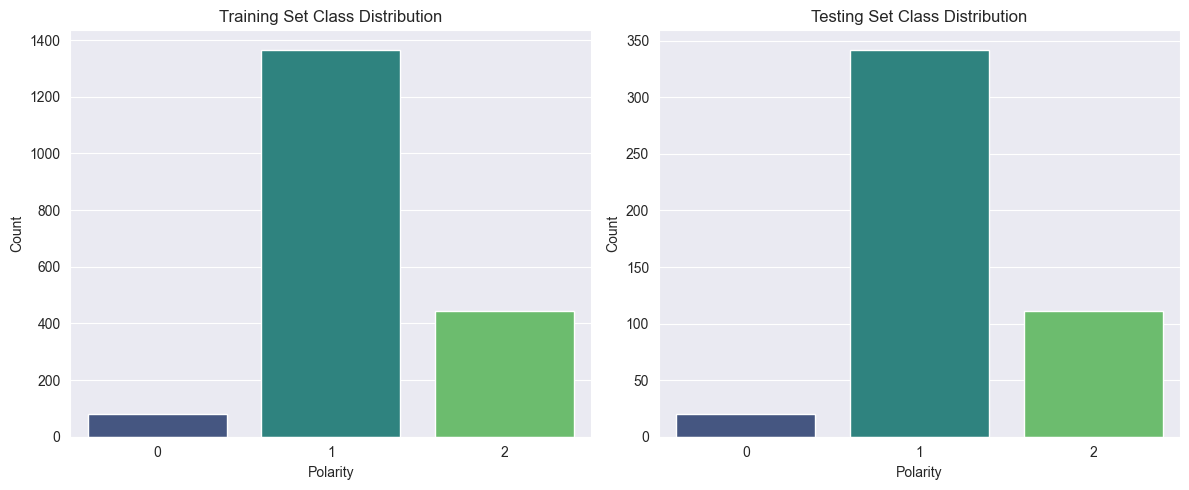

Final Evaluation: 100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


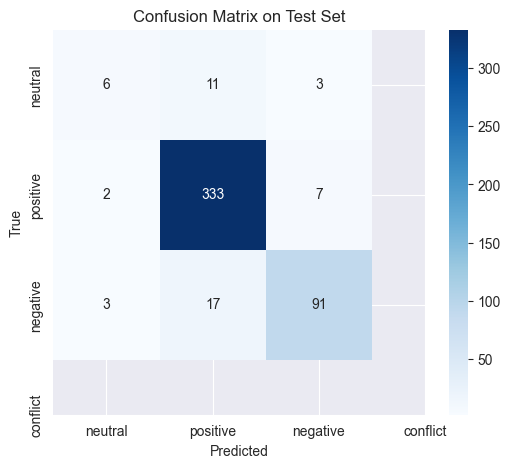


Classification Report on Test Set:
              precision    recall  f1-score   support

     neutral       0.55      0.30      0.39        20
    positive       0.92      0.97      0.95       342
    negative       0.90      0.82      0.86       111

    accuracy                           0.91       473
   macro avg       0.79      0.70      0.73       473
weighted avg       0.90      0.91      0.90       473



In [42]:
# Import necessary libraries
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os

# Import custom preprocessing functions
# Ensure that these modules are available in your project
from src.preprocessing.preprocess_dataframe import preprocess_dataframe
from src.preprocessing.vocabulary_builder import VocabularyBuilder

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Data Preparation
# -----------------------------

# Polarity encoding mapping (including 'conflict')
polarity_encoding = {
    'neutral': 0,
    'positive': 1,
    'negative': 2,
    'conflict': 3,  # Added 'conflict' to the mapping
}


# Function to load and preprocess data
def load_and_preprocess_data(train_path, test_path):
    # Load the training and testing data
    restaurant_df_train = pd.read_csv(
        train_path,
        encoding='utf8'
    )
    test_df = pd.read_csv(
        test_path,
        encoding='utf8'
    )

    # Combine both train and test data for preprocessing
    df = pd.concat([restaurant_df_train, test_df], ignore_index=True)


    return preprocess_dataframe(df)


# Paths to the dataset
train_csv_path = "data/SemEval16/Train/Restaurants_Train.csv"
test_csv_path = "data/SemEval16/Test/Restaurants_Test.csv"

# Load and preprocess data
df = load_and_preprocess_data(train_csv_path, test_csv_path)

# Split into train, validation, and test sets with stratification
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['polarity_encoded']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1,
    random_state=42,
    stratify=train_val_df['polarity_encoded']
)

# Reset index after split
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# -----------------------------
# 2. Device Configuration
# -----------------------------

# Check for available device (preferably GPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')  # For Apple Silicon Macs
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# -----------------------------
# 3. Tokenizer and BERT Model Setup
# -----------------------------

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# -----------------------------
# 4. Dataset and DataLoader
# -----------------------------

class BertAspectDataset(Dataset):
    """
    Custom Dataset for BERT-based Aspect Sentiment Analysis.
    """

    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentence = row['raw_text']
        aspect = row['aspect_term']
        label = row['polarity_encoded']

        # Use tokenizer's ability to handle two separate texts
        encoding = self.tokenizer(
            text=sentence,
            text_pair=aspect,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),  # [max_length]
            'attention_mask': encoding['attention_mask'].squeeze(),  # [max_length]
            'token_type_ids': encoding['token_type_ids'].squeeze(),  # [max_length]
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Create dataset instances
train_dataset = BertAspectDataset(train_df, tokenizer, max_length=128)
val_dataset = BertAspectDataset(val_df, tokenizer, max_length=128)
test_dataset = BertAspectDataset(test_df, tokenizer, max_length=128)

# Create DataLoader instances
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# -----------------------------
# 5. Model Definition
# -----------------------------

class BERT_AttentionLSTM_Enhanced(nn.Module):
    """
    Integrated BERT with LSTM and Enhanced Attention for Aspect-Based Sentiment Analysis.
    """

    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERT_AttentionLSTM_Enhanced, self).__init__()
        self.bert = bert_model
        self.sentence_lstm = nn.LSTM(
            bert_model.config.hidden_size,
            hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.aspect_lstm = nn.LSTM(
            bert_model.config.hidden_size,
            hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.attention = nn.Linear(hidden_dim * 4, 1)  # Enhanced attention
        self.fc = nn.Linear(hidden_dim * 4, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Pass combined sentence and aspect through BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = bert_outputs.last_hidden_state  # [batch, seq_len, hidden_size]

        # Split the sequence into sentence and aspect parts based on token_type_ids
        # token_type_ids == 0: sentence, ==1: aspect
        sentence_mask = token_type_ids == 0  # [batch, seq_len]
        aspect_mask = token_type_ids == 1  # [batch, seq_len]

        # Extract sentence embeddings
        sentence_embs = last_hidden_state * sentence_mask.unsqueeze(-1)  # [batch, seq_len, hidden_size]
        # Extract aspect embeddings
        aspect_embs = last_hidden_state * aspect_mask.unsqueeze(-1)  # [batch, seq_len, hidden_size]

        # Pass through LSTMs
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embs)  # [batch, seq_len, hidden_dim*2]
        aspect_lstm_out, _ = self.aspect_lstm(aspect_embs)  # [batch, seq_len, hidden_dim*2]

        # Compute mean of aspect embeddings
        aspect_mean = torch.mean(aspect_lstm_out, dim=1).unsqueeze(1)  # [batch, 1, hidden_dim*2]

        # Tile aspect_mean to match sentence length
        aspect_tiled = aspect_mean.repeat(1, sentence_lstm_out.size(1), 1)  # [batch, sentence_len, hidden_dim*2]

        # Combine sentence and aspect embeddings
        combined_embs = torch.cat([sentence_lstm_out, aspect_tiled], dim=-1)  # [batch, sentence_len, hidden_dim*4]

        # Apply enhanced attention
        attention_scores = self.attention(combined_embs).squeeze(-1)  # [batch, sentence_len]
        alpha = torch.softmax(attention_scores, dim=1).unsqueeze(-1)  # [batch, sentence_len, 1]
        attended = combined_embs * alpha  # [batch, sentence_len, hidden_dim*4]
        context = torch.sum(attended, dim=1)  # [batch, hidden_dim*4]

        # Pass through fully connected layer
        out = self.dropout(context)
        logits = self.fc(out)  # [batch, num_classes]

        return logits, alpha


# Initialize the enhanced model
hidden_dim = 256
num_classes = len(polarity_encoding)  # neutral, positive, negative, conflict
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BERT_AttentionLSTM_Enhanced(bert_model, hidden_dim, num_classes).to(device)

# -----------------------------
# 6. Training Setup
# -----------------------------

# Calculate class weights to handle class imbalance
y_train = train_df['polarity_encoded'].tolist()
class_counts = Counter(y_train)
print("Class Counts:", class_counts)  # Debugging line

total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights.get(i, 1.0) for i in range(num_classes)], dtype=torch.float32).to(device)
print("Class Weights:", weights)  # Debugging line

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Define optimizer with a higher learning rate
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# Define scheduler
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# -----------------------------
# 7. Training and Evaluation Functions
# -----------------------------

from torch.nn.utils import clip_grad_norm_


def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    """
    Trains the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs, _ = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * input_ids.size(0)

        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train

    return epoch_loss, epoch_acc


def eval_model(model, data_loader, criterion, device):
    """
    Evaluates the model on a validation or test set.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs, _ = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * input_ids.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch_f1 = f1_score(labels_list, preds_list, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1, preds_list, labels_list


# -----------------------------
# 8. Training Loop with Early Stopping
# -----------------------------

# Early Stopping parameters
best_f1 = 0
patience = 3
counter = 0
best_model_path = 'best_model.pt'

# Lists to store metrics
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
val_f1_list = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader, criterion, device)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

    # Early Stopping Check
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")
    else:
        counter += 1
        print(f"No improvement in F1 for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# -----------------------------
# 9. Inference on Sample Sentence
# -----------------------------

test_sentence = (
    "The decor is night tho...but they REALLY need to clean that vent in the ceiling...its quite "
    "un-appetizing, and kills your effort to make this place look sleek and modern."
)
test_aspects = ["place", "decor", "vent"]


def preprocess_input_bert_embeddings(sentence, aspect, tokenizer, max_length=128):
    """
    Preprocess the input sentence and aspect to obtain BERT inputs.

    Args:
        sentence (str): The raw sentence.
        aspect (str): The aspect term.
        tokenizer: BERT tokenizer.
        max_length (int): Maximum token length.

    Returns:
        dict: Dictionary containing 'input_ids', 'attention_mask', and 'token_type_ids'.
    """
    encoding = tokenizer(
        text=sentence,
        text_pair=aspect,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return {
        'input_ids': encoding['input_ids'].squeeze().to(device),
        'attention_mask': encoding['attention_mask'].squeeze().to(device),
        'token_type_ids': encoding['token_type_ids'].squeeze().to(device)
    }


# Invert polarity encoding for interpretation
inv_polarity = {v: k for k, v in polarity_encoding.items()}

# Set model to evaluation mode
model.eval()
print("\nInference on Sample Sentence:")
with torch.no_grad():
    for aspect in test_aspects:
        # Preprocess the input sentence and aspect
        inputs = preprocess_input_bert_embeddings(test_sentence, aspect, tokenizer, max_length=128)
        input_ids = inputs['input_ids'].unsqueeze(0)  # [1, max_length]
        attention_mask = inputs['attention_mask'].unsqueeze(0)  # [1, max_length]
        token_type_ids = inputs['token_type_ids'].unsqueeze(0)  # [1, max_length]

        # Predict using the trained model
        outputs, attention_weights = model(input_ids, attention_mask, token_type_ids)
        pred_label = torch.argmax(outputs, dim=1).item()

        print(f"Aspect: '{aspect}', Predicted Sentiment: {inv_polarity[pred_label]}")


# -----------------------------
# 10. Visualization & Metrics
# -----------------------------

# 1. Class Distribution Plot
def plot_class_distribution(train_df, val_df, test_df, polarity_encoding):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    sns.countplot(x='polarity_encoded', data=train_df, ax=ax[0], palette='viridis')
    ax[0].set_title('Training Set Class Distribution')
    ax[0].set_xlabel('Polarity')
    ax[0].set_ylabel('Count')
    ax[0].set_xticklabels([k for k, v in sorted(polarity_encoding.items(), key=lambda item: item[1])])

    sns.countplot(x='polarity_encoded', data=val_df, ax=ax[1], palette='viridis')
    ax[1].set_title('Validation Set Class Distribution')
    ax[1].set_xlabel('Polarity')
    ax[1].set_ylabel('Count')
    ax[1].set_xticklabels([k for k, v in sorted(polarity_encoding.items(), key=lambda item: item[1])])

    sns.countplot(x='polarity_encoded', data=test_df, ax=ax[2], palette='viridis')
    ax[2].set_title('Testing Set Class Distribution')
    ax[2].set_xlabel('Polarity')
    ax[2].set_ylabel('Count')
    ax[2].set_xticklabels([k for k, v in sorted(polarity_encoding.items(), key=lambda item: item[1])])

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_df, val_df, test_df, polarity_encoding)


# 2. Confusion Matrix & Classification Report on Test Set
def evaluate_on_test_set(model, test_loader, criterion, device, polarity_encoding):
    model.eval()
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs, _ = model(input_ids, attention_mask, token_type_ids)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(labels_list, preds_list)

    # Define labels in order
    labels_order = sorted(polarity_encoding, key=polarity_encoding.get)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["neutral", 'positive', "negative"],
                yticklabels=["neutral", 'positive', "negative"])
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Generate and print classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(labels_list, preds_list, target_names=["neutral", 'positive', "negative"]))

    # Overall Accuracy
    overall_acc = accuracy_score(labels_list, preds_list)
    print(f"Overall Test Accuracy: {overall_acc:.4f}")


evaluate_on_test_set(model, test_loader, criterion, device, polarity_encoding)


# 3. Training and Validation Metrics Plot
def plot_training_history(train_loss, train_acc, val_loss, val_acc, val_f1):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy and F1
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.plot(epochs, val_f1, 'g-', label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(train_loss_list, train_acc_list, val_loss_list, val_acc_list, val_f1_list)

